Author: Zidong Chen

Date: 2024/07/19

In [2]:
import torch
import torch.nn as nn
from data_sample import generate_example_data as data
from matplotlib import pyplot as plt
import core.GP_CommonCalculation as GP
from core.kernel import RBFKernel, LinearKernel, ARDKernel,RationalQuadraticKernel, PeriodicKernel
import numpy as np
from core.cigp_baseline import cigp
# I use torch (1.11.0) for this work. lower version may not work.
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' # Fixing strange error if run in MacOS
JITTER = 1e-6
EPS = 1e-10
PI = 3.1415

In [3]:
class NeuralKernel(nn.Module):
    def __init__(self, input_dim):
        super(NeuralKernel, self).__init__()

        # 定义核函数
        self.kernels = nn.ModuleDict({
            'RationalQuadratic': RationalQuadraticKernel(input_dim),
            'linear': LinearKernel(input_dim),
            'periodic': PeriodicKernel(input_dim),
            'ARD':ARDKernel(input_dim)
        })
        self.softplus= nn.Softplus()
        # 定义核函数的可学习权重
        self.weights = nn.ParameterDict({
            'RationalQuadratic': nn.Parameter(torch.tensor(1.0)),
            'linear': nn.Parameter(torch.tensor(1.0)),
            'periodic': nn.Parameter(torch.tensor(1.0)),
            'ARD':nn.Parameter(torch.tensor(1.0))
        })

    def forward(self, x1, x2):
        # 计算每个核函数的输出并加权相加
        K_sum = sum(self.softplus(self.weights[name]) * kernel(x1, x2)
                    for name, kernel in self.kernels.items())
        return K_sum

In [4]:
# generate example data
torch.manual_seed(0)
xtr=torch.rand(200,1)*20
ytr=torch.sin(xtr)+torch.randn_like(xtr)*0.1
xte=torch.linspace(0,20,1000).view(-1,1)
yte=torch.sin(xte)

In [5]:
x_dim= xtr.size(1)
NKGP=cigp(xtr, ytr,NeuralKernel(x_dim))
NKGP.train_adam(300,0.1)

1
iter 0 nll:589.33096
1
1
1
1
1
1
1
1
1
1
iter 10 nll:490.83949
1
1
1
1
1
1
1
1
1
1
iter 20 nll:396.36187
1
1
1
1
1
1
1
1
1
1
iter 30 nll:300.29254
1
1
1
1
1
1
1
1
1
1
iter 40 nll:204.94160
1
1
1
1
1
1
1
1
1
1
iter 50 nll:113.00191
1
1
1
1
1
1
1
1
1
1
iter 60 nll:33.36505
1
1
1
1
1
1
1
1
1
1
iter 70 nll:-22.27125
1
1
1
1
1
1
1
1
1
1
iter 80 nll:-62.43095
1
1
1
1
1
1
1
1
1
1
iter 90 nll:-55.60115
1
1
1
1
1
1
1
1
1
1
iter 100 nll:-64.32323
1
1
1
1
1
1
1
1
1
1
iter 110 nll:-64.34063
1
1
1
1
1
1
1
1
1
1
iter 120 nll:-65.51273
1
1
1
1
1
1
1
1
1
1
iter 130 nll:-65.52230
1
1
1
1
1
1
1
1
1
1
iter 140 nll:-65.63928
1
1
1
1
1
1
1
1
1
1
iter 150 nll:-65.72082
1
1
1
1
1
1
1
1
1
1
iter 160 nll:-65.73159
1
1
1
1
1
1
1
1
1
1
iter 170 nll:-65.75673
1
1
1
1
1
1
1
1
1
1
iter 180 nll:-65.77162
1
1
1
1
1
1
1
1
1
1
iter 190 nll:-65.78403
1
1
1
1
1
1
1
1
1
1
iter 200 nll:-65.79397
1
1
1
1
1
1
1
1
1
1
iter 210 nll:-65.80487
1
1
1
1
1
1
1
1
1
1
iter 220 nll:-65.81390
1
1
1
1
1
1
1
1
1
1
iter 230 nll:-65.7615

1
1
1


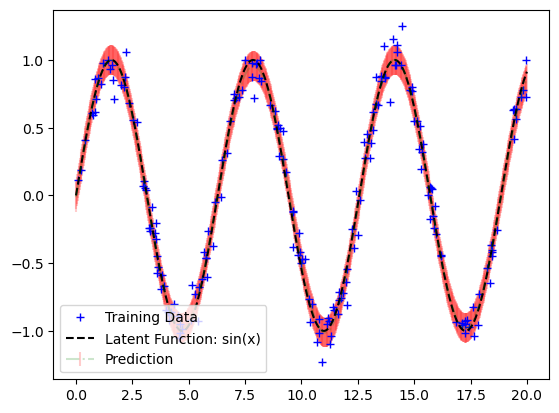

Weight for ARD kernel: -4.742368909251884
Weight for RationalQuadratic kernel: -1.3903647387313731
Weight for linear kernel: -6.288042969024414
Weight for periodic kernel: 7.072490254197522


In [6]:
with torch.no_grad():
    ypred, yvar = NKGP.forward(xte)
# Plotting the predictions with error bars
plt.errorbar(xte.numpy().reshape(1000), ypred.detach().numpy().reshape(1000),
             yerr=yvar.sqrt().squeeze().detach().numpy(), fmt='-.', color='g', ecolor='red', alpha=0.2, label='Prediction')

# Plotting the training data
plt.plot(xtr.numpy(), ytr.numpy(), 'b+', label='Training Data')

# Adding the latent function for reference
plt.plot(xte.numpy().reshape(1000), np.sin(xte.numpy().reshape(1000)), 'k--', label='Latent Function: sin(x)')

# Adding legend
plt.legend()
plt.show()
for name, param in NKGP.kernel.weights.items():
    print(f"Weight for {name} kernel: {param.item()}")

In [7]:
#Comparing with standard GP
standardGP=cigp(xtr, ytr,ARDKernel(1))
standardGP.train_adam(200,0.1)
with torch.no_grad():
    ypred2, yvar2 = standardGP.forward(xte)
mse_neuralKernel = ((yte - ypred) ** 2).mean()
mse_standardGP = ((yte - ypred2) ** 2).mean()
print('mse_neuralKernel:',mse_neuralKernel)
print('mse_standardGP:',mse_standardGP)

iter 0 nll:587.70160
iter 10 nll:490.64106
iter 20 nll:400.11676
iter 30 nll:326.43752
iter 40 nll:288.72468
iter 50 nll:288.39266
iter 60 nll:287.83814
iter 70 nll:285.97347
iter 80 nll:286.21229
iter 90 nll:286.00269
iter 100 nll:285.97557
iter 110 nll:285.96998
iter 120 nll:285.95818
iter 130 nll:285.95759
iter 140 nll:285.95448
iter 150 nll:285.95332
iter 160 nll:285.95191
iter 170 nll:285.95086
iter 180 nll:285.94988
iter 190 nll:285.94903
mse_neuralKernel: tensor(0.0005)
mse_standardGP: tensor(0.4899)


### Conclusion
#### The neural kernel demonstrated here is a linear combination of multiple kernels where the weights of each kernel are learned during training. The neural kernel can be used to model complex patterns in the data. In this example, the neural kernel is used to model a periodic function. The neural kernel is compared with the standard GP with ARD kernel. We can see that the neural kernel GP performs better than the standard GP in this example. The coefficients of each kernel are learned during training. After training, the weight for the periodic kernel is 1.59, and the weight of the other kernel is negative and close to zero after applying the softplus function. This aligns with the fact that the data is generated from a periodic function. This demonstrates that the neural kernel is a simple and effective way to automatically choose the kernel function for GP. You can change the data into a straight line to see how the neural kernel can automatically choose the linear kernel to model the data.